In [173]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report


In [174]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2286004498855171164
]
Num GPUs Available:  0


In [175]:
df = pd.read_json('../datasets/7_dataset_w_tags.json')
df = df[:20000]
df['Dep'] = df['Dep'].str.upper()
df.head()

,Sentence #,Word,Lemma,Tag,POS,Dep,Polarity,Gender
0,1,organizations,organization,NNS,NOUN,NSUBJ,-0.193345,W
1,1,decided,decide,VBN,VERB,ROOT,-0.034137,W
2,1,drop,drop,VB,VERB,XCOMP,-0.066243,W
3,1,women,woman,NNS,NOUN,NSUBJ,0.353161,W
4,1,accused,accuse,VBD,VERB,ADVCL,-0.015817,W


<AxesSubplot:>

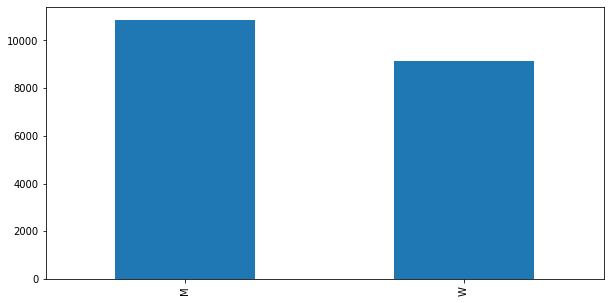

In [176]:
df["Gender"].value_counts().plot(kind="bar", figsize=(10,5))

In [177]:
word_vocab = np.unique(df['Word']).tolist()
sentiment_vocab = np.unique(df['Gender']).tolist()

i_to_word = {i:word for  i, word in enumerate(word_vocab)}
word_to_i = {word:i for  i, word in enumerate(word_vocab)}

i_to_sentiment = {i:sent for  i, sent in enumerate(sentiment_vocab)}
sentiment_to_i = {sent:i for  i, sent in enumerate(sentiment_vocab)}

df['Word_index'] = df['Word'].map(word_to_i)
df['Gender_index'] = df['Gender'].map(sentiment_to_i)

df_grouped = df.groupby(['Sentence #'],as_index=False)['Word', 'Word_index', 'Lemma', 'POS', 'Dep', 'Polarity', 'Gender', 'Gender_index'].agg(lambda x: list(x))
df_grouped = df_grouped.sample(frac=1).reset_index(drop=True)

df_grouped.head(10)

C:\Users\hanse\AppData\Local\Temp/ipykernel_10040/3461208999.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(['Sentence #'],as_index=False)['Word', 'Word_index', 'Lemma', 'POS', 'Dep', 'Polarity', 'Gender', 'Gender_index'].agg(lambda x: list(x))


,Sentence #,Word,Word_index,Lemma,POS,Dep,Polarity,Gender,Gender_index
0,2165,"[hearing, scheduled, determine, new, testimoni...","[3140, 4953, 2268, 3947, 5555, 5975, 1169, 205...","[hearing, schedule, determine, new, testimony,...","[NOUN, VERB, VERB, ADJ, NOUN, NOUN, VERB, NOUN...","[NSUBJ, ACL, ROOT, AMOD, NSUBJPASS, POBJ, CCOM...","[-0.029049195250236002, -0.059430069044206, -0...","[W, W, W, W, W, W, W, W, W, W, W]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,1677,"[dropped, read, covered, hard, reset, way, fie...","[2399, 4611, 2062, 3113, 4781, 5917, 2784, 558...","[drop, read, cover, hard, reset, way, field, t...","[VERB, NOUN, VERB, ADJ, NOUN, NOUN, NOUN, VERB...","[ROOT, NSUBJPASS, ADVCL, AMOD, DOBJ, NPADVMOD,...","[-0.066243199290966, -0.02694436178916, 0.0673...","[M, M, M, M, M, M, M, M, M, M, M, M, M, M]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,2086,"[Till, died, lynched, white, woman, falsely, c...","[891, 2284, 3706, 5942, 5973, 2724, 1770, 1571...","[Till, die, lynch, white, woman, falsely, clai...","[PROPN, VERB, VERB, ADJ, NOUN, ADV, VERB, ADV,...","[ADVMOD, ADVCL, ROOT, AMOD, NSUBJ, ADVMOD, ADV...","[0.000177373239709, -0.042543604415901, -4.828...","[W, W, W, W, W, W, W, W, W, W]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
3,1979,"[Reuters, T, Mobile, Inc, agreed, acquire, pee...","[769, 875, 603, 468, 1142, 1040, 4184, 846, 25...","[Reuters, T, Mobile, Inc, agree, acquire, peer...","[PROPN, PROPN, PROPN, PROPN, VERB, VERB, NOUN,...","[APPOS, COMPOUND, COMPOUND, NSUBJ, ROOT, XCOMP...","[-0.130397087722324, -0.012525123680323, -0.02...","[M, M, M, M, M, M, M, M, M, M, M, M, M, M, M, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,2014,"[beginning, Griffin, told, ESPN]","[1443, 413, 5615, 301]","[beginning, Griffin, tell, ESPN]","[NOUN, PROPN, VERB, PROPN]","[ATTR, NSUBJ, ROOT, DOBJ]","[-0.015055608398499001, -0.0049964263150190005...","[M, M, M, M]","[0, 0, 0, 0]"
5,2,"[Women, previously, worked, winning, actor, to...","[970, 4403, 5984, 5958, 1053, 5615, 171, 4743,...","[woman, previously, work, win, actor, tell, CN...","[NOUN, ADV, VERB, VERB, NOUN, VERB, PROPN, ADV...","[NSUBJ, ADVMOD, RELCL, AMOD, POBJ, ROOT, DOBJ,...","[0.35316112487835105, -0.039333311401716003, -...","[W, W, W, W, W, W, W, W, W, W, W, W, W, W, W]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
6,2573,"[deflect, attention, accusers, lives, careers,...","[2194, 1318, 1033, 3659, 1643, 3110, 2182, 311...","[deflect, attention, accuser, live, career, ha...","[VERB, NOUN, NOUN, VERB, NOUN, NOUN, ADV, VERB...","[CCOMP, DOBJ, POBJ, NSUBJ, CONJ, DOBJ, ADVMOD,...","[-0.006412359565719001, -0.034776147566450005,...","[W, W, W, W, W, W, W, W, W, W, W, W, W, W]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
7,2559,"[stories, feature, unnamed, friends, confidant...","[5335, 2755, 5766, 2935, 1920, 2241, 1163, 505...","[story, feature, unnamed, friend, confidant, d...","[NOUN, VERB, ADJ, NOUN, NOUN, VERB, VERB, ADJ,...","[NSUBJ, RELCL, AMOD, DOBJ, CONJ, ACL, AMOD, AM...","[-0.007520434991955, 0.004448754625146, -0.009...","[W, W, W, W, W, W, W, W, W, W, W, W, W, W, W, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
8,1337,"[Derby, reserved, thoroughbreds]","[281, 4780, 5575]","[Derby, reserve, thoroughbred]","[PROPN, VERB, NOUN]","[NSUBJPASS, ROOT, POBJ]","[-0.009952121284115, -0.028874421156560002, -0...","[M, M, M]","[0, 0, 0]"
9,1568,"[teach, sermons, high, school, help, kids, poi...","[5510, 5028, 3167, 4959, 3156, 3502, 4293, 3622]","[teach, sermon, high, school, help, kid, point...","[VERB, NOUN, ADJ, NOUN, VERB, NOUN, NOUN, NOUN]","[ROOT, DOBJ, AMOD, POBJ, CONJ, DOBJ, POBJ, POBJ]","[-0.03229449203409, 0.0019919514635140002, -0....","[M, M, M, M, M, M, M, M]","[0, 0, 0, 0, 0, 0, 0, 0]"


In [178]:
max_word = len(word_vocab)
max_sent = len(sentiment_vocab)

words = df_grouped['Word_index'].tolist()
sentiments = df_grouped['Gender_index'].tolist()


max_length = max([len(w) for w in words])

pad_words = pad_sequences(words, maxlen=max_length, dtype='float32', padding='post', value= max_word - 1)

pad_sentiment = pad_sequences(sentiments, maxlen=max_length, dtype='float32', padding='post')
n_sentiments = len(sentiment_to_i)

pad_sentiment = [to_categorical(i, num_classes=n_sentiments) for i in pad_sentiment]

train_words, test_words, train_sentiments, test_sentiments = train_test_split(pad_words, pad_sentiment, test_size=0.4, random_state=42, shuffle=True)


In [191]:
pad_sentiment

[array([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=float32),
 array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1.

In [180]:
input_dim = len(word_vocab)+1
output_dim = 64
input_length = max([len(s) for s in df_grouped['Word_index'].tolist()])

In [181]:
model = tf.keras.models.Sequential(
    [
        layers.Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length), # Embedding vs Input layer
        layers.Bidirectional(layers.LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'),
        layers.LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5),
        layers.TimeDistributed(layers.Dense(n_sentiments, activation="softmax")) #Use softmax for activation HOML page 383
    ]
)

adam = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

#Hyper params to change - learning rate, number of layers and neurons, activations functions

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 
model.summary()
plot_model(model)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 38, 64)            385856    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 38, 128)           66048     
_________________________________________________________________
lstm_25 (LSTM)               (None, 38, 64)            49408     
_________________________________________________________________
time_distributed_12 (TimeDis (None, 38, 2)             130       
Total params: 501,442
Trainable params: 501,442
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [182]:
root_logdir = os.path.join(os.curdir, "sa_logs")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
run_log_dir

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

In [183]:
from keras import callbacks

print(train_words.shape)
print(np.array(train_sentiments).shape)

# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
                                        
history = model.fit(train_words, np.array(train_sentiments), epochs=1, callbacks=[tensorboard_cb])
#model.save("bidir_lstm.h5")

(1328, 38)
(1328, 38, 2)
42/42 [==============================] - 12s 107ms/step - loss: 0.3348 - accuracy: 0.8796


In [188]:
train_words

array([[3331., 1331., 1828., ..., 6027., 6027., 6027.],
       [3794.,  801.,  219., ..., 6027., 6027., 6027.],
       [1046., 5480., 4751., ..., 6027., 6027., 6027.],
       ...,
       [1870., 4702., 3361., ..., 6027., 6027., 6027.],
       [2937., 4923., 6027., ..., 6027., 6027., 6027.],
       [5316., 5273., 5975., ..., 6027., 6027., 6027.]], dtype=float32)

In [184]:
y_pred = model.predict(test_words) #Calculates probability for each tag

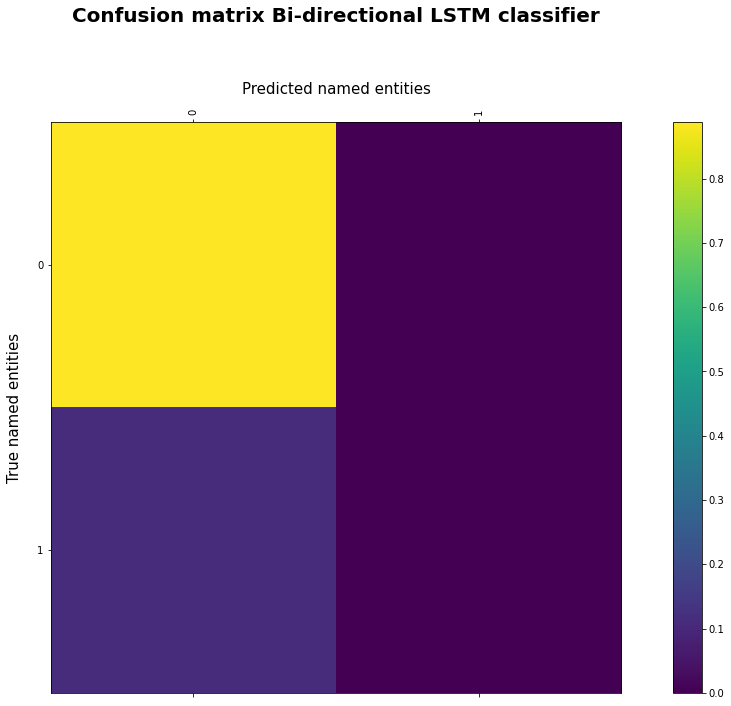

In [185]:
y_classes = y_pred.argmax(axis=-1)

cm_true = y_classes.flatten()
cm_pred = np.array(test_sentiments).argmax(axis=-1).flatten()

cm = confusion_matrix(cm_pred, cm_true, normalize='pred')
fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted gender', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True gender', fontsize = 15, labelpad=15.0)
ax.set_title('Confusion matrix Bi-directional LSTM classifier',fontweight="bold", size=20, pad=100.0)

fig.colorbar(cax)
plt.xticks(range(2), ["Masculine","Feminine"], rotation=90)
plt.yticks(range(2), ["Masculine","Feminine"])
plt.show()

In [186]:
report = classification_report(cm_true, cm_pred, output_dict=True)
df_perf = pd.DataFrame.from_dict(report).transpose()
df_perf_2 = df_perf[:2]
df_perf_2.insert(loc=0, column='Gender', value=sentiment_vocab)
df_perf_2.precision = df_perf_2.precision.round(2)
df_perf_2.recall = df_perf_2.recall.round(2)
df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)
df_perf_2.support = df_perf_2.support.round()
df_perf_2.reset_index(drop=True, inplace=True)


df_perf_2

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarni

,Gender,precision,recall,f1-score,support
0,M,1.0,0.89,0.94,33668.0
1,W,0.0,0.00,0.00,0.0
